## Imports

In [1]:
## Link: https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py
%load_ext autoreload
%autoreload 2

import os
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

import scipy.signal as scisig
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib as mpl
import heartpy as hp
import biosppy
import neurokit2 as nk
from heartpy.datautils import *
from heartpy.peakdetection import *
mpl.rcParams['agg.path.chunksize'] = 10000
from time import time
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
import csv 
from multiprocessing import Pool
from copy import copy

import warnings
warnings.filterwarnings('ignore')
from fb_models import *
from datetime import datetime
import logging
now = datetime.now().strftime('%Y-%m-%d-%H-%M%p')

logging.basicConfig(level=logging.INFO, filename='logs/'+now+'.log', force=True)



# Feature Extraction

Features coded:

ECG: mean, std, min, max, bpm, ibi, sdnn, sdsd, rmssd, pnn20, pnn50, 


PPG/BVP: mean, std, min, max, peak_freq

TEMP:mean, std, min, max, drange, slope

RESP: mean, std, min, max, rate; Inh: mean, std; Exh: mean, std, I/E


EDA: mean, std, min, max, slipe, drange; SCR: mean, std, min, max; SCL: mean, std, min, max

ACC x,y,z; chest, wrist:  mean, std, min, max, abs_integral, peak_freq
Acc net: mean, std, min, max, abs_integral, peak_freq


Features not coded yet:


To replicate this study with similar modalities to RADWear, I will drop the following signals: EDA_c, EMG, TEMP_C

## Parameters

In [2]:
# E4 (wrist) Sampling Frequencies
fs_dict = {
    'ACC': 32,
    'BVP': 64,
    'EDA': 4,
    'TEMP': 4,
    'label': 700,
    'Resp': 700,
    'ECG': 700,
    'chest': 700,
}
# Window size
WINDOW_IN_SECONDS = 60
stride = 10

# Labels
label_dict = {'baseline': 1, 'stress': 2, 'amusement': 0}
# Int to label mappings
int_to_label = {1: 'baseline', 2: 'stress', 0: 'amusement'}
# Feature names
feat_names = None
# Where to save the data
drive = 'E:/'
#loadPath = '/C/Users/alkurdi/Desktop/Vansh/data/WESAD'
loadPath = "E:/Users/alkurdi/data/WESAD"
#loadPath_GN = '/C/Users/alkurdi/Desktop/Vansh/data/GN-WESAD'
loadPath_GN = "E:/Users/alkurdi/data/GN-WESAD"

# Where to get the data
subject_feature_path = '/subject_feats'
fb_model_list = ['DT', 'RF', 'SVM', 'LDA', 'KNN', 'AB','XGB']

if not os.path.exists(loadPath):
    os.makedirs(loadPath)
if not os.path.exists(loadPath + subject_feature_path):
    os.makedirs(loadPath + subject_feature_path)

We want to reduce modalities in WESAD data such that it matches RADWear modalities. 

In [3]:
# Data import
def read_n_reduce(path):
    df = pd.read_csv(path, index_col=0)
    df = df.drop(columns=['subject'], axis=1)
    pd.set_option('display.max_columns', None)
    # We want to drop columns in df that are not in RADWear to match modalities.
    # drop _c columns
    columns_list = df.columns.tolist()
    drop_list = []
    # df.drop(columns=['Resp_C'])
    for column in columns_list:
        if (
            'EMG' in column
            or 'EDA_C' in column
            or 'Temp_C' in column
            or 'TEMP_C' in column
            or 'SCR_C' in column
            or 'SCL_C' in column
        ):
            drop_list.append(column)

    reduced_df = df.drop(columns=drop_list)
    df = reduced_df
    return df

rel_path = '/subject_feats/WESADfeatures-win60stride10.csv'
df = read_n_reduce(loadPath + rel_path)

#df = read_n_reduce(loadPath + subject_feature_path + '/oct5_feats4.csv')



## Generate correlation between features and labels

In [4]:
#drop_list = ['net_acc_C_mean'	,'net_acc_C_std',	'net_acc_C_min'	,'net_acc_C_max', 'EDA_min',	'EDA_max',TEMP_min	TEMP_max net_acc_mean	net_acc_std	net_acc_min] EDA_SCR_mean EDA_SCL_std BVP_mean BVP_min BVP_max TEMP_mean TEMP_std TEMP_min	
#corr.drop(columns=drop_list) 

In [5]:
vals = abs(df.corr()['label']).sort_values(ascending=False)
if False:
    for i in range(len(vals)):
        print(vals.index[i], vals[i])

corr = df.corr()
drop_list = ['net_acc_C_mean'	,'net_acc_C_std',	'net_acc_C_min'	,'net_acc_C_max', 'EDA_min',	'EDA_max',]
plot_corr = False
if plot_corr:
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr, square=True)

In [6]:
corr = abs(df.drop(columns=['ECG_ibi', 'Resp_C_Exhal_mean', 'ECG_pnn20']).corr())
corr.shape

(90, 90)

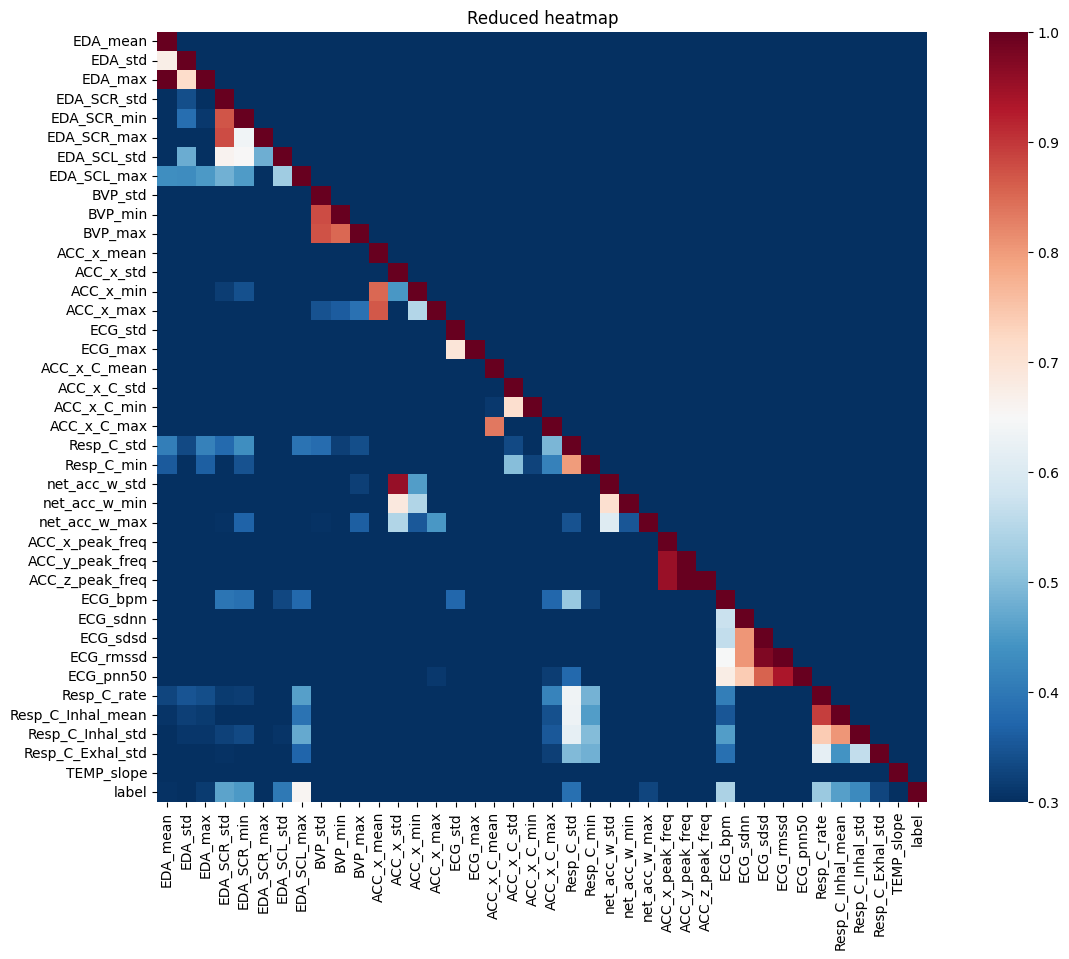

In [7]:
from calendar import c
import matplotlib.cm as cm
drop_list = ['net_acc_C_mean', 'net_acc_C_std', 'net_acc_C_min',
             'net_acc_C_max','ECG_ibi', 'Resp_C_Exhal_mean', 'ECG_pnn20',
             'net_acc_abs_integral', 'ACC_x_abs_integral',
             'ACC_y_abs_integral', 'ACC_z_abs_integral', 'net_acc_C_abs_integral',
             'ACC_y_std', 'ACC_y_min', 'ACC_y_max', 'ACC_z_mean', 'ACC_z_std',
             'ACC_z_min', 'ACC_z_max',
             'ACC_y_C_mean', 'ACC_y_C_std', 'ACC_y_C_min', 'ACC_y_C_max',
             'ACC_z_C_mean', 'ACC_z_C_std', 'ACC_z_C_min', 'ACC_z_C_max','Resp_C_max',
             'EDA_SCL_mean', 'EDA_SCL_min', 'TEMP_min', 'TEMP_max',
             'ACC_x_C_abs_integral','ACC_y_C_abs_integral', 'ACC_z_C_abs_integral',
             'TEMP_drange', 'ACC_y_mean', 'EDA_min']
corr_df = df.copy()#.reindex(sorted(df.columns), axis=1)
corr = abs(corr_df.drop(columns=drop_list).corr())


#conditions for filtering 0.6<=r<=0.9
val_min = 0.6
val_max = 0.9999


#two axis objects just for comparison purposes
labels = corr.columns.to_list()
my_cmap = copy(cm.RdBu_r)
#my_cmap.set_over("blue")
#my_cmap.set_under("white")

corr = corr.to_numpy()

#delete columns where all elements do not fulfill the conditions
ind_x,  = np.where(np.all(np.logical_or(corr<val_min, corr>val_max), axis=0))
ind_x = ind_x.tolist();ind_x.pop(-1)
corr = np.delete(corr, ind_x, 0)
corr = np.delete(corr, ind_x, 1)
map_labels = list(filter(lambda x: labels.index(x) not in ind_x, labels))


#now the same for rows 
ind_y, = np.where(np.all(np.logical_or(corr<val_min, corr>val_max), axis=1))
ind_y = ind_y.tolist();ind_y.pop(-1)
corr = np.delete(corr, ind_y, 0)
corr = np.delete(corr, ind_y, 1)

#update labels
map_labels = list(filter(lambda x: map_labels.index(x) not in ind_y, map_labels))

# use only lower triangle
corr = np.tril(corr)

#update labels
plt.figure(figsize=(16, 10))
#plot heatmap
g = sns.heatmap(corr,
    xticklabels=map_labels,
    yticklabels=map_labels,
    vmin=.3, #val_min,
    #vmax=val_max, 
    cmap=my_cmap,
    square=True)
g.set_title("Reduced heatmap")
plt.show()

In [8]:
# df = df.loc[:, df.columns != 'Resp_C_rate'] #I don't know why this is here.

features = df.loc[:, df.columns != 'label'].columns
print_feats_list = False
if print_feats_list:
    for ft_idx in range(len(features)):
        print(features[ft_idx], ft_idx)

## split data into train and test set

In [9]:
X = df.drop('label', axis=1).values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Modeling

## Cross Validation

### K-Fold Cross Validation

### Leave-One-Out Cross Validation

# Models 

The models will be included in this study are: 

DT, RF, SVM, AB, LDA and kNN. 

Completed: LDA, RF, SVM, AB, DT, kNN 

Incomplete: NaN 

## Linear Discriminant Analysis

--- 0.05635404586791992 seconds ---


<Figure size 640x480 with 0 Axes>

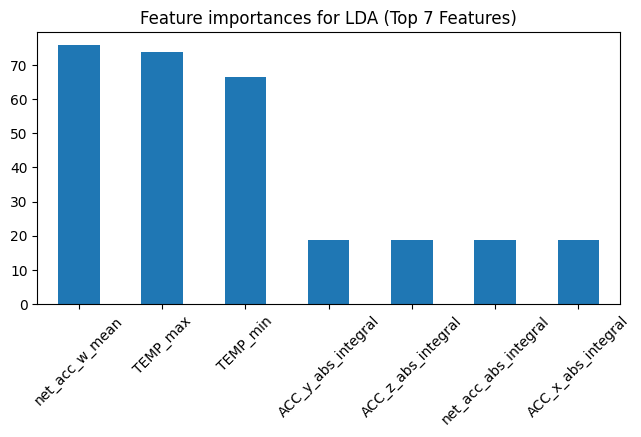

In [62]:
start_time = time()
lda_baseline_acc = run_lda(X_train, X_test, y_train, y_test)
lda_coefs = lda_baseline_acc['FI']
print("--- %s seconds ---" % (time() - start_time))

lda_importances = pd.Series(abs(lda_coefs[0]), index=features).sort_values(ascending=False)


# Sort the feature importances in descending order and select the top 5
top_5_importances = lda_importances.sort_values(ascending=False).head(7)
plt.figure()
fig, ax = plt.subplots()
top_5_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for LDA (Top 7 Features)")
#ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
ax.set_xticklabels(top_5_importances.index, rotation=45)
plt.show()

### Feature Importance (Top 20)

## Random Forest Classifier

--- 0.46640872955322266 seconds ---


<Figure size 640x480 with 0 Axes>

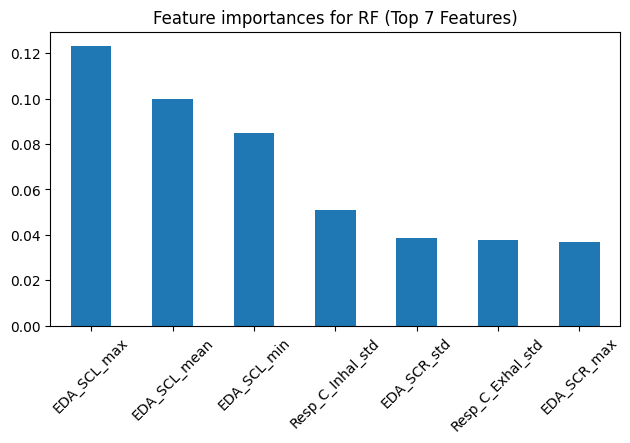

In [53]:
start_time = time()
rf_baseline_acc = run_rf(X_train, X_test, y_train, y_test)
importances = rf_baseline_acc['FI']
features = df.drop('label', axis=1).columns
forest_importances = pd.Series(importances, index=features).sort_values(ascending=False)
#print(forest_importances)
print("--- %s seconds ---" % (time() - start_time))

# Sort the feature importances in descending order and select the top 5
top_5_importances = forest_importances.sort_values(ascending=False).head(7)
plt.figure()
fig, ax = plt.subplots()
top_5_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for RF (Top 7 Features)")
#ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
ax.set_xticklabels(top_5_importances.index, rotation=45)
plt.show()

### Feature Importance (Top 20)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances[:20].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Support Vector Machine

### Linear SVM

--- 11.024158239364624 seconds ---


<Figure size 640x480 with 0 Axes>

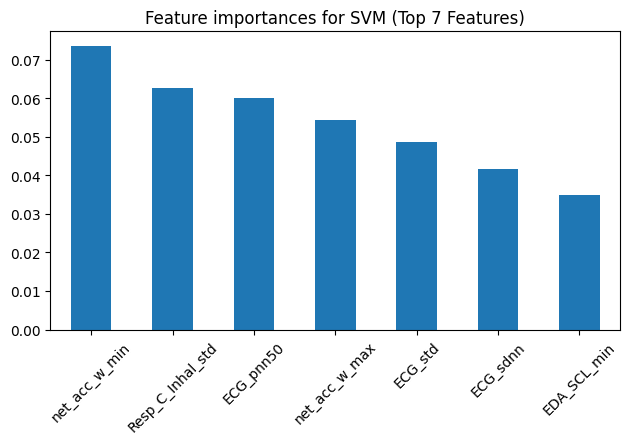

In [54]:
# measure time to run

start_time = time()
svm_baseline_acc = run_svm(X_train, X_test, y_train, y_test)
print("--- %s seconds ---" % (time() - start_time))
perm_importance = svm_baseline_acc['FI']

#svm2_baseline_acc = run_svm(
#    X_train, X_test, y_train, y_test, C=0.9
#)  # linear svm lambda 2

svm_importances = pd.Series(perm_importance.importances_mean, index=features).sort_values(ascending=False)
top_5_importances = svm_importances.sort_values(ascending=False).head(7)
plt.figure()
fig, ax = plt.subplots()
top_5_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for SVM (Top 7 Features)")
fig.tight_layout()
ax.set_xticklabels(top_5_importances.index, rotation=45)
plt.show()

## Adaboost 

<Figure size 640x480 with 0 Axes>

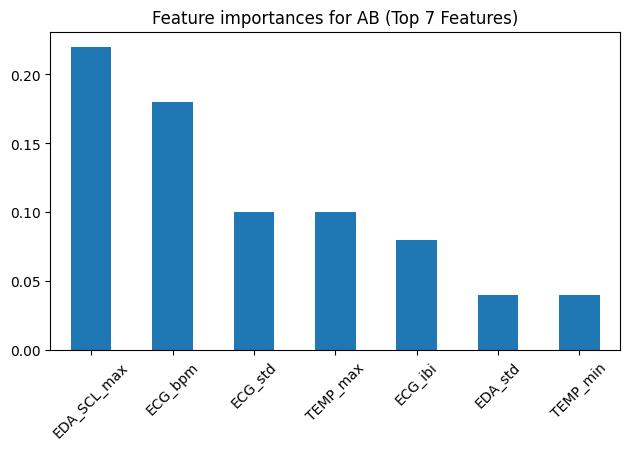

--- 0.989433765411377 seconds ---


In [58]:
# measure time to run

start_time = time()
ab_baseline = run_ab(X_train, X_test, y_train, y_test)

ab_importances = pd.Series(ab_baseline['FI'], index=features).sort_values(ascending=False)
top_5_importances = ab_importances.sort_values(ascending=False).head(7)
plt.figure()
fig, ax = plt.subplots()
top_5_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for AB (Top 7 Features)")
fig.tight_layout()
ax.set_xticklabels(top_5_importances.index, rotation=45)
plt.show()

print("--- %s seconds ---" % (time() - start_time))

## Xgboost 

--- 0.30976176261901855 seconds ---


<Figure size 640x480 with 0 Axes>

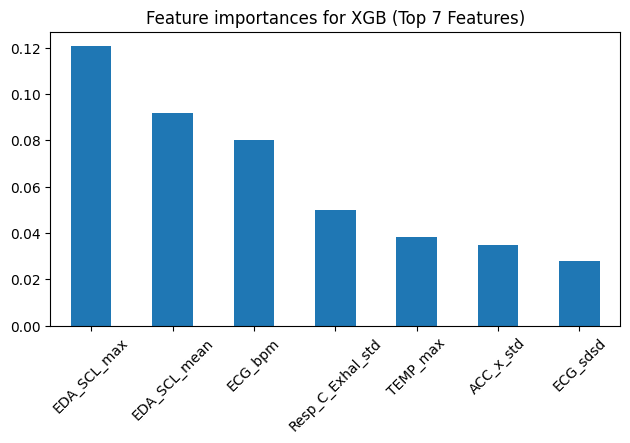

In [59]:
# measure time to run

start_time = time()
xgb_baseline = run_xgb(X_train, X_test, y_train, y_test)
print("--- %s seconds ---" % (time() - start_time))
#print('decision tree baseline accuracy: ' + str(xgb_baseline))

xgb_importances = pd.Series(xgb_baseline['FI'], index=features).sort_values(ascending=False)
top_5_importances = xgb_importances.sort_values(ascending=False).head(7)
plt.figure()
fig, ax = plt.subplots()
top_5_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for XGB (Top 7 Features)")
fig.tight_layout()
ax.set_xticklabels(top_5_importances.index, rotation=45)
plt.show()


## Decision Tree 

--- 0.09073352813720703 seconds ---


<Figure size 640x480 with 0 Axes>

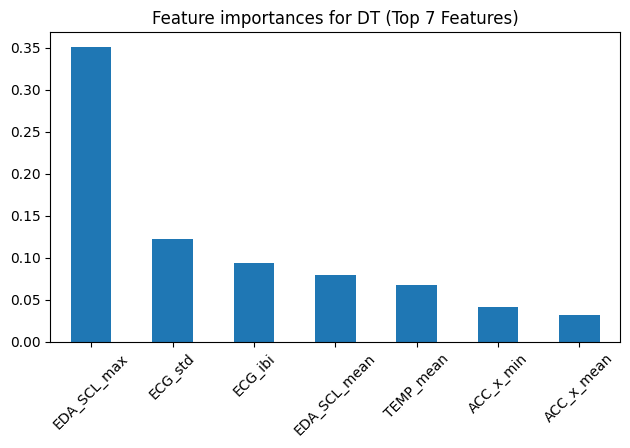

In [60]:
# measure time to run

start_time = time()
dt_baseline_acc = run_dt(X_train, X_test, y_train, y_test)
print("--- %s seconds ---" % (time() - start_time))
#print('decision tree baseline accuracy: ' + str(dt_baseline_acc))

dt_importances = pd.Series(dt_baseline_acc['FI'], index=features).sort_values(ascending=False)
top_5_importances = dt_importances.sort_values(ascending=False).head(7)
plt.figure()
fig, ax = plt.subplots()
top_5_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for DT (Top 7 Features)")
fig.tight_layout()
ax.set_xticklabels(top_5_importances.index, rotation=45)
plt.show()


### Feature Importance (Top 20)

## k-Nearest Neighbors 

--- 51.42097878456116 seconds ---


<Figure size 640x480 with 0 Axes>

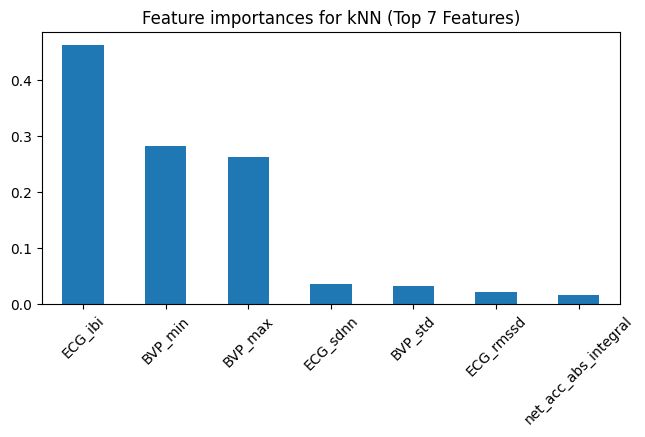

In [63]:
# measure time to run

start_time = time()
knn_baseline_acc = run_knn(X_train, X_test, y_train, y_test)
print("--- %s seconds ---" % (time() - start_time))

perm_importance = knn_baseline_acc['FI']
knn_importances = pd.Series(perm_importance.importances_mean, index=features).sort_values(ascending=False)
top_5_importances = knn_importances.sort_values(ascending=False).head(7)
plt.figure()
fig, ax = plt.subplots()
top_5_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for kNN (Top 7 Features)")
fig.tight_layout()
ax.set_xticklabels(top_5_importances.index, rotation=45)
plt.show()


In [ ]:
from fb_code.utils import calculate_binary_metrics

knn_f1_bin = calculate_binary_metrics(knn_baseline_acc['Confusion Matrix'])
dt_f1_bin = calculate_binary_metrics(dt_baseline_acc['Confusion Matrix'])
xgb_f1_bin = calculate_binary_metrics(xgb_baseline['Confusion Matrix'])
ab_f1_bin = calculate_binary_metrics(ab_baseline['Confusion Matrix'])
svm_f1_bin = calculate_binary_metrics(svm_baseline_acc['Confusion Matrix'])
rf_f1_bin = calculate_binary_metrics(rf_baseline_acc['Confusion Matrix'])
lda_f1_bin = calculate_binary_metrics(lda_baseline_acc['Confusion Matrix'])

print('kNN', round(100*knn_f1_bin,1),'%')
print('DT', round(100*dt_f1_bin,1),'%')
print('XGB', round(100*xgb_f1_bin,1),'%')
print('AB', round(100*ab_f1_bin,1),'%')
print('SVM', round(100*svm_f1_bin,1),'%')
print('RF', round(100*rf_f1_bin,1),'%')
print('LDA', round(100*lda_f1_bin,1),'%')


# Adding Noise

## Signal to Noise Ratio

For a non-constant signal $S$ and noise $N$, the signal to noise ratio is defined as the following:
$$ SNR = \frac{\mathbb{E}[S^2]}{\mathbb{E}[N^2]} $$

The expected value $\mathbb{E}[X]$ of any continuous random variable $X$ is $\int_{-\infty}^{\infty} x p(x) dx $, where $p(x)$ is its associated probability density function.

For homoskedastic noise, we can use closed form expressions to compute $E[N^2]$.

- For Gaussian distributed noise $N$ ~ $n(\mu, \sigma^2)$, notice that $\text{V}[N] = \mathbb{E}[N^2] - (\mathbb{E}[N])^2,$ so $\mathbb{E}[N^2] = \text{V}[N] + (\mathbb{E}[N])^2 = \sigma^2 + \mu$. In our case $\mu = 0$, so $\mathbb{E}[N^2] = \sigma^2$.

- For uniformly distributed noise $N$ ~ $u(\alpha, \beta)$, by the same logic as above $\mathbb{E}[N^2] = \left(\frac{\alpha - \beta}{2}\right)^2$.

- For frequency-domain noise $N$ of the form $A\sin(2\pi x \frac{1}{f}) + y, \mathbb{E}[N^2] \approx y^2 + \frac{A^2}{2}$. Note the $\approx$ since we cannot guarantee that the signal will end precisely on the end of the sin wave.

For heteroskedastic noise, because there is no closed form expression, we simply take `N.mean()` where $N$ is our noise

## Denoising Using Principal Component Analysis

Let $X$ represent our set of physiological signals and $\textbf{x}_i$ denote the *i*-th column of $X$. In our case, $\textbf{x}_i$ is one of the ECG, BVP, EDA, ACC, etc. The post-noise signal we observe $\textbf{x}_i = \widetilde{\textbf{x}}_i + \xi_i$ is composed of the original raw signal and Gaussian distributed noise with $\mathbb{E}[\xi] = 0$ and $V[\xi] = E[N^2] = \sigma^2 = \frac{\mathbb{E}[S^2]}{SNR}$. Literature has indicated that a principal component analysis of $\textbf{x}_i$ can produce an estimate of $\widetilde{\textbf{x}}_i$ that is closer than the noisy measurements are (citation needed).

## Calculate Distribution Parameters from SNR

Given a signal $S$, we can specify a signal to noise ratio $SNR = \frac{\mathbb{E}[S^2]}{\mathbb{E}[N^2]}$ and use this to calculate $\mathbb{E}[N^2]$ because $SNR$ and $\mathbb{E}[S^2]$ are known. So $\mathbb{E}[N^2] = \frac{\mathbb{E}[S^2]}{SNR}$.

Then, for any homoskedastic noise following a well-defined probability density function (PDF), we can solve for the parameters of the PDF using the known value $\mathbb{E}[N^2]$.

- For Gaussian distributed noise $N$ ~ $n(\mu, \sigma^2)$, notice that $\text{V}[N] = \mathbb{E}[N^2] - (\mathbb{E}[N])^2,$ so $\mathbb{E}[N^2] = \text{V}[N] + (\mathbb{E}[N])^2 = \sigma^2 + \mu$. In our case $\mu = 0$, so $\mathbb{E}[N^2] = \sigma^2$. Thus, $\sigma^2 = \frac{\mathbb{E}[S^2]}{SNR}$.

## Gaussian Noise

The Gaussian probability density function is of the following form:
\begin{equation}
f(x) = \frac{1}{\sigma \sqrt{2 \pi}}exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right)
\end{equation}

### Estimating $\mu$ and $\sigma$ of the Gaussian

#### Greatest $n$-Differential with Homoskedasticity Approach

For a signal $S$, the greatest $n$-differential with homoskedasticity approach constructs a Gaussian distribution such that $\mu$ = 0 and $\sigma = \alpha \cdot max(|S_i - S_{i+n}|)$, where $max(|S_i - S_{i+n}|)$ denotes the maximum absolute difference of the signal between index $i$ and $i+n$ in the entire signal, and $\alpha$ is a parameter that multiplicatively scales the intensity of the added noise. We can choose to set $n$ to any value, although we have empirically found $n = 5$ to be the best. We set $\mu$ to $0$ so we don't vertically shift the original signal after adding noise. 

In conclusion, we randomly sample from the following probability density function:
$$
f(x) = \frac{1}{\alpha \cdot max(|S_i - S_{i+n}|) \sqrt{2 \pi}}exp\left(-\frac{1}{2}\left(\frac{x}{\alpha \cdot max(|S_i - S_{i+n}|)}\right)^2\right)
$$

This noise exhbits homoskedasticity because it does not vary with time.

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
axs[0].plot(np.ravel(patients_new_noise1[0]['signal']['chest']['Resp']))
axs[0].set_title('SNR: 0.01')
axs[1].plot(np.ravel(patients_new_noise2[0]['signal']['chest']['Resp']))
axs[1].set_title('SNR: 0.05')
axs[2].plot(np.ravel(patients_new_noise3[0]['signal']['chest']['Resp']))
axs[2].set_title('SNR: 0.1')
axs[3].plot(np.ravel(patients_new_noise4[0]['signal']['chest']['Resp']))
axs[3].set_title('SNR: 0.2')
axs[4].plot(np.ravel(patients_new_noise5[0]['signal']['chest']['Resp']))
axs[4].set_title('SNR: 0.5')

# Data Preparation (pt. 2)

Prepare the data again, this time with the noisy data

In [64]:
# snrs = [0.00001, 0.0001,  0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6] # this is biggest list we'd need
snrs = [
    0.0001,
    0.001,
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
]  # this is what we ran #0.00001,
n_samples = 10  # number of samples taken per SNR
subject_feature_path = '/subject_feats'
n_samples = 10
subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
fb_model_list = ['DT', 'RF', 'LDA', 'KNN', 'AB', 'SVM', 'XGB']
cases = ['WESAD', 'GN-WESAD', 'PR-WESAD']

# Modeling (pt. 2)

Model again, this time with the noisy data

In [ ]:
features = df.loc[:, df.columns != 'label'].columns

# Compare Results

Compare the results of the noisy data models and the clean data models

- Plots of SNR (x-axis) vs. accuracy (y-axis)
- Compare feature importances across different noise regimes
    - Develop dynamic evaluation method based on original feature importance / added noise

## Test Each Model Architecture

In [ ]:
# read data
gn_wesad_day = '2023-11-13'
e2e_model_list = ['LSTM', 'CNN', 'GRU', 'RNN']  # placeholder for now
cases = ['WESAD', 'GN-WESAD', 'PR-WESAD']

results_table = pd.DataFrame(columns=['SNR', 'Accuracy', 'F1-Score',
                                          'dataset', 'n_i', 'noise gen function',
                                          'Precision', 'Recall','Model'])
print(type(results_table))

results_table = pd.concat([results_table, pd.Series({'SNR' : 'N / A',
                                                'Accuracy' : 0,
                                                'F1 Score' : 0,
                                                'dataset': 'WESAD',
                                                'n_i': 0, 
                                                'noise gen function': 'None',
                                                'Precision': 0,
                                                'Recall': 0,
                                                'Model': 0})] )
j = 0

In [ ]:
logging.basicConfig(
    level=logging.INFO, filename='logs/testing.log', filemode='w', force=True
)  # remove after testing
logging.getLogger().addHandler(logging.StreamHandler())

from fb_models import *  # i need this here for testing to reload modules everytime.


def gn_wesad_path(n_i, snr):
    #loadPath = '/mnt/d/Users/alkurdi/data/GN-WESAD'
    # print(f'{loadPath}/n_{n_i}/snr_{snr}{subject_feature_path}/{gn_wesad_day}_feats2.csv')
    return (
        f'{loadPath_GN}/n_{n_i}/snr_{snr}{subject_feature_path}/{gn_wesad_day}_feats2.csv'
    )


def e2e_model(df, model):
    # this is mostly going to be fetching the data.
    # maybe check if results are already there. if yes, return them.
    # if not, run the model via sbatch script and return the results.
    e2e_results_path = '../data/e2e_results'  # this is just a placeholder for now
    accuracy = []
    precision = []
    f1 = []

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': precision,
        'f1_score': f1,
    }  # ab_baseline_acc, ab2_baseline_acc, f1


def get_model(the_splits, model, n_i, snr):
    model_output = {}
    logging.info(
        'started model: ' + model + ' for SNR: ' + str(snr) + ' n_i: ' + str(n_i)
    )
    X_train, X_test, y_train, y_test = the_splits
    if model == 'SVM':
        model_output = run_svm(X_train, X_test, y_train, y_test)
    elif model == 'KNN':
        model_output = run_knn(X_train, X_test, y_train, y_test)
    elif model == 'DT':
        model_output = run_dt(X_train, X_test, y_train, y_test)
    elif model == 'LDA':
        model_output = run_lda(X_train, X_test, y_train, y_test)
    elif model == 'RF':
        model_output = run_rf(X_train, X_test, y_train, y_test)
    elif model == 'AB':
        model_output = run_ab(X_train, X_test, y_train, y_test)
    elif model == 'XGB':
        model_output = run_xgb(X_train, X_test, y_train, y_test)
    if snr == 'N/A':
        dataset = 'WESAD'
        n_samples = 1
    else:
        dataset = 'GN-WESAD'
        n_samples = 10
    results_table = pd.Series(
        {
            'SNR': snr,
            'Accuracy': model_output['Accuracy'],
            'F1 Score': model_output['F1 Score'],
            'dataset': dataset,
            'n_i': n_i,
            'n': n_samples,
            'noise gen function': 'Gaussian Noise',
            'Precision': model_output['Precision'],
            'Recall': model_output['Recall'],
            'Model': model,
        }
    )
    classification_report = {
        'Classification Report': model_output['Classification Report'],
        'id': [snr, n_i, model],
    }
    confusion_matrix = {
        'Confusion Matrix': model_output['Confusion Matrix'],
        'id': [snr, n_i, model],
    }
    logging.info(
        'completed model: ' + model + ' for SNR: ' + str(snr) + ' n_i: ' + str(n_i)
    )
    return results_table, confusion_matrix, classification_report


def split_data(df, test_size=0.2, random_state=0):
    # split data into features and labels
    X = df.drop('label', axis=1).values
    y = df['label'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return [X_train, X_test, y_train, y_test]


def run_wesad_models():
    # check if wesad_model_results.csv exists
    target_file = (
        loadPath +'/wesad_models_results-win60stride1_wcm_wcr_1-12-2024.csv'
    )
    if os.path.isfile(target_file) and False:
        logging.info('WESAD results table found. Loading...')
        results_table = pd.read_csv(target_file, index_col=0)
        cm_cr_dict = pickle.load(
            open(loadPath+'/cm_cr_dict.pickle', 'rb')
        )
    else:
        logging.info('WESAD results table not found. Running models...')
        #loadPath = '/mnt/d/Users/alkurdi/data/WESAD'
        rel_path = '/subject_feats/WESADfeatures-win60stride10.csv'
        df = read_n_reduce(loadPath + rel_path)
        # print('features used for fb_models\n', *df.columns, sep='\n')
        cm_list = []
        cr_list = []
        results_table = pd.DataFrame(
            columns=[
                'SNR',
                'Accuracy',
                'F1 Score',
                'dataset',
                'n_i',
                'n',
                'noise gen function',
                'Precision',
                'Recall',
                'Model',
            ]
        )
        print('Initlizing results table...')
        the_splits = split_data(df)
        for model in fb_model_list:
            model_output, cm, classification_report = get_model(
                the_splits, model, 1, 'N/A'
            )
            cm_list.append(cm)
            cr_list.append(classification_report)
            results_table = results_table.append(model_output, ignore_index=True) # type: ignore
        results_table.to_csv(target_file)
        cm_cr_dict = {'cm': cm_list, 'cr': cr_list}
        with open(loadPath + '/cm_cr_dict.pickle', 'wb') as handle:
            pickle.dump(cm_cr_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        logging.info(
            'WESAD models ran and results generated and saved in: ' + target_file
        )
    return results_table, cm_cr_dict


def each_n_snr(n_i, snr):
    logging.info('SNR: ' + str(snr) + ' n_i: ' + str(n_i) + ' started.')
    cm_list = []
    instance_table = pd.DataFrame(
        columns=[
            'SNR',
            'Accuracy',
            'F1 Score',
            'dataset',
            'n_i',
            'n',
            'noise gen function',
            'Precision',
            'Recall',
            'Model',
        ]
    )
    logging.info('progress: ' + str(i) + '/' + str(n_samples * len(snrs)))
    file_path = gn_wesad_path(n_i, snr)
    df = read_n_reduce(file_path)
    df = df.dropna()
    the_splits = split_data(df)
    with Pool() as pool:
        # run each model for each snr ni pair in parallel
        instance_table, classification_report = pool.map(
        get_model, zip(the_splits, fb_model_list, [n_i] * len(fb_model_list), [snr] * len(fb_model_list)) # type: ignore
        )
        pool.close()
        
            
    '''
    for model in fb_model_list:
        logging.info('started model: '+ model+ ' for SNR: '+ str(snr)+ ' n_i: '+ str(n_i))
        model_output, classification_report = get_model(the_splits, model, n_i, snr)
        instance_table = instance_table.append(model_output, ignore_index=True)
    '''
    logging.info('SNR: ' + str(snr) + ' n_i: ' + str(n_i) + ' done.')
    return instance_table, classification_report


def run_GN_models():
    # check if GN wesad_model_results.csv exists
    tgt_file = loadPath_GN + '/GN_wesad_models_results_wcm_wcr.csv'
    if os.path.isfile(tgt_file):
        logging.info('GN-WESAD results table found. Loading...')
        results_table = pd.read_csv(tgt_file, index_col=0)
        cm_cr_dict = pickle.load(
            open(loadPath_GN + '/cm_cr_dict.pickle', 'rb')
        )
    else:
        logging.info('GN-WESAD results table not found. Running models...')
        i = 0
        cm_list = []
        cr_list = []
        results_table = pd.DataFrame(
            columns=[
                'SNR',
                'Accuracy',
                'F1 Score',
                'dataset',
                'n_i',
                'n',
                'noise gen function',
                'Precision',
                'Recall',
                'Model',
            ]
        )
        # the difference mainly between WESAD and GN-WESAD is that GN-WESAD has multiple snrs.
        
        ##############################
        for n_i in range(n_samples):
            for snr in snrs:
                i += 1
                logging.info('progress: ' + str(i) + '/' + str(n_samples * len(snrs)))
                file_path = gn_wesad_path(n_i, snr)
                df = read_n_reduce(file_path)
                df = df.dropna()
                df = df.drop(columns=['n_i', 'snr'])
                # print('features used for GN fb_models\n', *df.columns, sep='\n')
                the_splits = split_data(df)
                for model in fb_model_list:
                    model_output, cm, classification_report = get_model(
                        the_splits, model, n_i, snr
                    )
                    cm_list.append(cm)
                    cr_list.append(classification_report)
                    results_table = results_table.append(
                        model_output, ignore_index=True
                    ) # type: ignore
                    '''
                    results_table = pd.concat([results_table, pd.Series({'SNR' : snr,
                                                        'Accuracy' : model_output['Accuracy'],
                                                        'F1 Score' : model_output['F1 Score'],
                                                        'dataset': 'GN-WESAD',
                                                        'n_i': n_i, 'n': n_samples,
                                                        'noise gen function': 'Gaussian Noise',
                                                        'Precision': model_output['Precision'],
                                                        'Recall': model_output['Recall'],
                                                        'Model': model})])
                    '''
        ####################################
        results_table.to_csv(tgt_file)
        cm_cr_dict = {'cm': cm_list, 'cr': cr_list}
        with open(loadPath_GN+'/cm_cr_dict.pickle', 'wb') as handle:
            pickle.dump(cm_cr_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        logging.info(
            'GN-WESAD models ran and results generated and saved in: ' + tgt_file
        )
    return results_table, cm_cr_dict

In [ ]:
# For each case of the study to noise ratio
for case in cases:
    if case == 'WESAD':
        logging.info('Running WESAD case...')
        WESAD_model_results, wesad_cm_cr_dict = run_wesad_models()
    if case == 'GN-WESAD':
        logging.info('Running GN-WESAD case...')
        GN_model_results, gn_cm_cr_dict = run_GN_models()
    if case == 'PR-WESAD':
        logging.info('Running PR-WESAD case...')
        #loadPath = '/mnt/d/Users/alkurdi/data/PR-WESAD'
logging.info('Done running models. Generating results table...')

## Ammend results with Binary F1 score

In [ ]:
# class 2 is stress in WESAD for the FB models. 
gn_cm_cr_dict['cm']

In [ ]:
GN_model_results

In [ ]:
from fb_code.utils import  *

wesad_results, gn_wesad_results = ammend_results_table(GN_model_results, gn_cm_cr_dict,
                                                       WESAD_model_results, wesad_cm_cr_dict,
                                                       cases)

In [ ]:
wesad_results

In [ ]:
gn_wesad_results

In [ ]:
wesad_results['noise gen function'] = 'None'  #'noise gen function']
gn_wesad_results['Binary F1'] = gn_wesad_results['Binary F1'].astype(float)

## Exploring GN cases for E2E models 

After finding the results generated on the traditional ML models, we need to peform further refinmenet due to the significant cost related to running E2E models. Therefore, we would like to run minimal amounts of runs for with smallest n possible and and fewer snrs as possible. Picking the snrs from the plots was not difficult. The 3 snrs will be ran for the E2E models are going to be for the a snr where performance tanks, snr with performance is still good but impact is starting to be clear, and another snr in between both sides. These 3 snrs are: [0.01, .15, 0.4]. 
The next step is to evaluate how much difference has been observed when FB-ML algorithms were deployed. To do that, we need to see if there is a significant variance between the different samples for each of the 10 snrs, we ran. A box plot, or violin plot would be ideal for this task to exentuate the intra-sample difference. 

In [ ]:
wesad_results

In [ ]:
import seaborn as sns

sns.set_theme(style='whitegrid')
sns.set_context('paper')
sns.set(font_scale=1)
sns.violinplot(
    x='Model',
    y='Binary F1',
    #hue='',
    data=gn_wesad_results,
    palette='Set3',
    linewidth = 2,
    width=2,
    
)
#make plot wider
plt.title('Violin Plot of F1 Scores for GN-WESAD');

The spread looks great for kNN but DT and SVM perform better on the higher end with tigher grouping. so it would be more appropriate to dig in deeper to learn more about their behaviours. So let's break the same data down across SNRS instead models. 

Below we can see the result of that. 

In [ ]:
import seaborn as sns

sns.set_theme(style='whitegrid')
sns.set_context('paper')
sns.set(font_scale=1)
sns.violinplot(
    x='SNR',
    y='Binary F1',
    #hue='Model',
    data=gn_wesad_results,
    palette='Set3',
    linewidth = 2,
    width=2.5,
    legend = 'full'
)
#make plot wider
plt.ylim([.5,1.05])
plt.title('Violin Plot of F1 Scores for GN-WESAD');

plt.figure(figsize=(12, 8))
import seaborn as sns

sns.set_theme(style='whitegrid')
sns.set_context('paper')
sns.set(font_scale=1)
sns.violinplot(
    x='SNR',
    y='Binary F1',
    hue='Model',
    data=gn_wesad_results,
    palette='Set3',
    linewidth = 1.5,
    width=2.5,
    legend = 'full'
)
#make plot wider
plt.ylim([.5,1.05])

plt.title('Violin Plot of F1 Scores for GN-WESAD');

#make plot wider


plt.figure(figsize=(12, 8))
import seaborn as sns

sns.set_theme(style='whitegrid')
sns.set_context('paper')
sns.set(font_scale=1)
sns.violinplot(
    x='SNR',
    y='Binary F1',
    #hue='Model',
    data=gn_wesad_results[gn_wesad_results['Model'] != 'AB' ],
    palette='Set3',
    linewidth = 1.5,
    width=1,
    legend = 'full'
)
#make plot wider
plt.ylim([.5,1.05])

plt.title('Violin Plot of F1 Scores for GN-WESAD');

#make plot wider





Initially we see interesting behaviour. For some reason, the performance of the model is lower on average, in low noise, than with moderate noise, and then it gets worse, expectedly, as higher noise is added. This is not what we expected. We expected the model to perform better with less noise. This is not the case. We will investigate this further. I expect the culprit is AB, so i will isolate, and also breakdown the violens into smaller ones. And from the second and 3rd figure, what expect is indeed what we see from the data and removing AB shows better behavrious. 

It would be reasonable to assume that performance from 1 gaussian noise function to another, the variation is not significant, which is also shown by the p-value being 1 across all combinations, which is a strong evidence that the mean performances are indeed what they are, instead of being random. 

Just to confirm, I will, finally, plot another figure slicing across the sample sizes to see how the data is distributed. 

In [ ]:
import seaborn as sns

sns.set_theme(style='whitegrid')
sns.set_context('paper')
sns.set(font_scale=1)
sns.violinplot(
    x='n_i',
    y='Binary F1',
    #hue='',
    data=gn_wesad_results,
    palette='Set3',
    linewidth = 2,
    width=2,
    
)
#make plot wider
plt.ylim([.5,1.05])
plt.title('Violin Plot of F1 Scores for GN-WESAD');

plt.figure()
sns.set_theme(style='whitegrid')
sns.set_context('paper')
sns.set(font_scale=1)
sns.violinplot(
    x='n_i',
    y='Binary F1',
    #hue='',
    data=gn_wesad_results[gn_wesad_results['Model'] != 'AB' ],
    palette='Set3',
    linewidth = 2,
    width=2,
    
)
#make plot wider
plt.ylim([.5,1.05])

plt.title('Violin Plot of F1 Scores for GN-WESAD');



In [ ]:
import seaborn as sns
plt.figure(figsize=(20, 4))

sns.set_theme(style='whitegrid')
sns.set_context('paper')
sns.set(font_scale=1)
sns.violinplot(
    x='n_i',
    y='Binary F1',
    hue='Model',
    data=gn_wesad_results,
    palette='Set3',
    linewidth = .3,
    #width=1.3,
    
)
#make plot wider

plt.ylim([.5,1.05])
plt.title('Violin Plot of F1 Scores for GN-WESAD');
plt.savefig('out.eps', format='eps', dpi=1200)


import seaborn as sns
plt.figure(figsize=(20, 4))

sns.set_theme(style='whitegrid')
sns.set_context('paper')
sns.set(font_scale=1)
sns.violinplot(
    x='n_i',
    y='Binary F1',
    hue='SNR',
    data=gn_wesad_results,
    palette='Set3',
    linewidth = .3,
    #width=1.3,
    
)
#make plot wider

plt.ylim([.5,1.05])
plt.title('Violin Plot of F1 Scores for GN-WESAD');
plt.savefig('out.eps', format='eps', dpi=1200)


In [ ]:
sns.set_theme(style='whitegrid')
sns.set_context('paper')
sns.set(font_scale=1)
sns.scatterplot(
    x='SNR',
    y='F1 Score',
    hue='n_i',
    data=gn_wesad_results[gn_wesad_results['Model'] == 'KNN' ],
    palette='Set3',
    #linewidth = 2,
    #width=2.5,
    #legend = 'full'
)
#make plot wider
#plt.ylim([.5,1.05])

plt.title('Violin Plot of F1 Scores for GN-WESAD');

# What about Specificity?  

While the F1 Score provides a balance between precision and recall for the positive class, specificity solely measures the accuracy of predictions for the negative class. Both are important for understanding different aspects of a classification model's performance.




$$ F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall} $$
$$ Specificity_i = \frac{TN_i}{TN_i + FP_i} $$
$$ TN_i = \sum_{j=1}^{N} \sum_{k=1}^{N} matrix[j][k] \quad \text{for} \quad j \neq i \quad \text{and} \quad k \neq i $$
$$ FP_i = \sum_{j=1}^{N} matrix[j][i] \quad \text{for} \quad j \neq i $$
$$ Precision = \frac{TP}{TP + FP} $$
$$ Recall = \frac{TP}{TP + FN} $$

$$ where $$ 
Performance metric most important for health application is specificity. 
So let's reframe the discussion with specificity at the center... 

In [ ]:
g = sns.pairplot(gn_wesad_results.drop(columns=['n', 'Precision','Recall','Accuracy', 'F1 Score']), height=3.5,hue='Model')
g.fig.suptitle('Pairplot of GN-WESAD Results hue= Model', y=1.08)

h = sns.pairplot(gn_wesad_results.drop(columns=['n', 'Precision','Recall','Accuracy', 'F1 Score']), height=3.5,hue='SNR')
h.fig.suptitle('Pairplot of GN-WESAD Results hue= SNR', y=1.08)

i = sns.pairplot(gn_wesad_results.drop(columns=['n', 'Precision','Recall','Accuracy', 'F1 Score']), height=3.5,hue='n_i')
i.fig.suptitle('Pairplot of GN-WESAD Results hue= n_i', y=1.08)



In [ ]:
# tabulate and plot
with open(loadPath + '/cm_cr_dict.pickle', 'rb') as handle:
    WESAD_cm_cr_dict = pickle.load(handle)
with open(loadPath_GN + '/cm_cr_dict.pickle', 'rb') as handle:
    GN_cm_cr_dict = pickle.load(handle)
combined_results = pd.concat([WESAD_model_results, GN_model_results])

In [ ]:
combined_results

In [ ]:
if os.path.isfile(loadPath_GN + '/gn_means_df.pickle'):
    print('file exists, will load it')
    gn_means_df = pd.read_pickle(
        loadPath_GN + '/gn_means_df.pickle'
    )
else:
    print('file does not exist, will create it')
    gn_means_df = pd.DataFrame(
        columns=[
            'SNR',
            'Accuracy',
            'F1 Score',
            'dataset',
            'n_i',
            'n',
            'noise gen function',
            'Precision',
            'Recall',
            'Model',
        ]
    )
    for snr in snrs:
        for model in fb_model_list:
            # display(GN_model_results[GN_model_results['SNR'] == snr][GN_model_results['Model'] == model])
            one_case = (
                GN_model_results[GN_model_results['SNR'] == snr][
                    GN_model_results['Model'] == model
                ]
                .mean(axis=0)
                .rename('mean')
            )
            one_case_df = one_case.to_frame().T
            one_case_df = pd.concat(
                [
                    one_case_df,
                    GN_model_results[GN_model_results['SNR'] == snr][
                        GN_model_results['Model'] == model
                    ]
                    .std(axis=0)
                    .rename('std')
                    .to_frame()
                    .T,
                ]
            )
            one_batch = GN_model_results[GN_model_results['SNR'] == snr][
                GN_model_results['Model'] == model
            ]
            res = stats.ttest_1samp(
                one_batch['F1 Score'].values,
                one_batch['F1 Score'].mean(),
            )
            one_case_df['Model'] = model
            one_case_df['dataset'] = 'GN-WESAD'
            one_case_df['noise gen function'] = 'Gaussian Noise'
            one_case_df['n'] = n_samples
            one_case_df['SNR'] = snr
            one_case_df['p-value'] = res.pvalue
            gn_means_df = pd.concat([gn_means_df, one_case_df])
            # deep_gn = pd.join(deep_gn, one_case)
    gn_means_df.to_pickle(loadPath_GN + '/gn_means_df.pickle')
gn_means_df['n'] = gn_means_df['n'].astype(int)
# display(gn_means_df)

In [ ]:
ggn_means_df = pd.DataFrame(
    columns=[
        'SNR',
        'Accuracy',
        'F1 Score',
        'dataset',
        'n_i',
        'n',
        'noise gen function',
        'Precision',
        'Recall',
        'Model',
    ]
)
for snr in snrs:
    for model in fb_model_list:
        # display(GN_model_results[GN_model_results['SNR'] == snr][GN_model_results['Model'] == model])
        one_case = (
            GN_model_results[GN_model_results['SNR'] == snr][
                GN_model_results['Model'] == model
            ]
            .mean(axis=0)
            .rename('mean')
        )
        one_case_df = one_case.to_frame().T
        one_case_df = pd.concat(
            [
                one_case_df,
                GN_model_results[GN_model_results['SNR'] == snr][
                    GN_model_results['Model'] == model
                ]
                .std(axis=0)
                .rename('std')
                .to_frame()
                .T,
            ]
        )

        one_batch = GN_model_results[GN_model_results['SNR'] == snr][
            GN_model_results['Model'] == model
        ]
        res = stats.ttest_1samp(
            one_batch['F1 Score'].values[0:4],
            one_batch['F1 Score'].mean(),
        )
        #print(res.pvalue)
        one_case_df['Model'] = model
        one_case_df['dataset'] = 'GN-WESAD'
        one_case_df['noise gen function'] = 'Gaussian Noise'
        one_case_df['n'] = n_samples
        one_case_df['SNR'] = snr
        one_case_df['p-value'] = res.pvalue
        ggn_means_df = pd.concat([ggn_means_df, one_case_df])

In [ ]:
wesad_file_wanted = loadPath + '/wesad_models_results-win60stride1_wbinaryf1.csv'
wesad_acc = pd.read_csv(wesad_file_wanted,index_col=0,)

## Plot SNR vs. Accuracy

In [ ]:
import pandas as pd
wesad_results.query('`Binary F1` > 0.98')


In [ ]:
# subset.loc['mean']
# plt.errorbar(x=snrs, y=subset.loc['mean']['Accuracy'], yerr=subset.loc['std']['Accuracy'], fmt='o')
wesad_results, gn_wesad_results
# now plot same with seaborn
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")
sns.set_context("paper")
sns.set(
    font_scale=1.2,
)
sns.set_style("ticks")
plt.figure(figsize=(12, 8))
ax = sns.lineplot(
    x="SNR", y="Binary F1", hue="Model", data=gn_wesad_results, marker='*'
)  # .set_title('GN-WESAD')
ax.hlines(
    y=wesad_results['Accuracy'].max(),
    xmin=0,
    xmax=0.6,
    linestyles='dashed',
    color='green',
)
plt.ylim([.5,1.05])
ax.hlines(y=0.7, xmin=0, xmax=0.6, linestyles='dashed', color='red')
ax.set_title('F1 Score vs SNR')
ax.set_ylim([0.6, 1])
ax.set_xlabel('Signal-to-Noise Ratio'), ax.set_ylabel('F1 Score')
ax.text(x=0.45, y=0.71, s='weighted guess', color='red', va='center', ha='center')
ax.text(x=0.45, y=0.98, s='best model: XGB = 99.4%', color='green', va='center', ha='center')
ax.legend(loc='upper left')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



In [ ]:
# subset.loc['mean']
# plt.errorbar(x=snrs, y=subset.loc['mean']['Accuracy'], yerr=subset.loc['std']['Accuracy'], fmt='o')
wesad_results, gn_wesad_results
# now plot same with seaborn
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")
sns.set_context("paper")
sns.set(
    font_scale=1.2,
)
sns.set_style("ticks")
plt.figure(figsize=(12, 8))
ax = sns.lineplot(
    x="SNR", y="Specificity", hue="Model", data=gn_wesad_results, marker='*'
)  # .set_title('GN-WESAD')
ax.hlines(
    y=wesad_results['Accuracy'].max(),
    xmin=0,
    xmax=0.6,
    linestyles='dashed',
    color='green',
)
#plt.ylim([.5,1.05])
#ax.hlines(y=0.7, xmin=0, xmax=0.6, linestyles='dashed', color='red')
ax.set_title('Specificity vs SNR')
#ax.set_ylim([0.6, 1])
ax.set_xlabel('Signal-to-Noise Ratio'), ax.set_ylabel('Specificity')
#ax.text(x=0.45, y=0.71, s='weighted guess', color='red', va='center', ha='center')
#ax.text(x=0.45, y=0.98, s='best model: XGB = 99.4%', color='green', va='center', ha='center')
ax.legend(loc='upper left')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



In [ ]:
# now plot same with seaborn
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")
sns.set_context("paper")
sns.set(
    font_scale=1.2,
)
sns.set_style("ticks")
plt.figure(figsize=(12, 8))
ax = sns.lineplot(
    x="SNR", y="Binary F1", hue="Model", data=gn_wesad_results, marker='*'
)  # .set_title('GN-WESAD')
ax.hlines(
    y=wesad_results['Accuracy'].max(),
    xmin=0,
    xmax=0.6,
    linestyles='dashed',
    color='green',
)
plt.ylim([.5,1.05])
ax.hlines(y=0.7, xmin=0, xmax=0.6, linestyles='dashed', color='red')
ax.set_title('F1 Score vs SNR')
ax.set_ylim([0.6, 1])
ax.set_xlabel('Signal-to-Noise Ratio'), ax.set_ylabel('F1 Score')
ax.text(x=0.45, y=0.71, s='weighted guess', color='red', va='center', ha='center')
ax.text(x=0.45, y=0.98, s='best model: XGB = 99.4%', color='green', va='center', ha='center')
ax.legend(loc='upper left')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Tabulate results 

In [ ]:
if os.path.isfile(
    drive + 'Users/alkurdi/data/w60s10_wesad_gn_combined_mean_performances.csv'
):
    print('file exists, will load it')
    combined_mean_performances = pd.read_csv(
        drive + 'Users/alkurdi/data/w60s10_wesad_gn_combined_mean_performances.csv',
        index_col=0,
    )
else:
    current_df = pd.DataFrame(
        columns=[
            'SNR',
            'Accuracy',
            'F1 Score',
            'dataset',
            'n_i',
            'n',
            'noise gen function',
            'Precision',
            'Recall',
            'Model',
        ]
    )
    for snr in snrs:
        for model in fb_model_list:
            current = (
                gn_wesad_results.loc[
                    (gn_wesad_results['SNR'] == snr)
                    & (gn_wesad_results['Model'] == model)
                ]
                .mean()
                .to_frame()
                .T
            )
            current['Binary F1 stdv'] = gn_wesad_results.loc[
                (gn_wesad_results['SNR'] == snr) & (gn_wesad_results['Model'] == model)
            ].std()['Binary F1']
            current['Accuracy stdv'] = gn_wesad_results.loc[
                (gn_wesad_results['SNR'] == snr) & (gn_wesad_results['Model'] == model)
            ].std()['Accuracy']
            current['Model'] = model
            current['dataset'] = 'GN-WESAD'
            current['noise gen function'] = 'Gaussian Noise'
            current_df = pd.concat([current_df, current])
            # display(current)
    combined_mean_performances = pd.concat([wesad_results, current_df])
    combined_mean_performances.to_csv(
        'data/w60s10_wesad_gn_combined_mean_performances.csv'
    )

In [ ]:
combined_mean_performances

## Feature Importances

In [ ]:
import scipy.stats as ss
'''
for ft in range(0, len(ft_imp_matrix)):
    ft_imp_matrix[ft] = [
        sorted(ft_imp_matrix[ft], reverse=True).index(x) for x in ft_imp_matrix[ft]
    ]
ft_imp_df = pd.DataFrame(ft_imp_matrix, columns=features)

ft_imp_df.head()
ft_imp_df.columns.values
ft_imp_df.reset_index().pivot(index=ft_imp_df, columns=ft_imp_df.columns.values)
'''

# E2E Models 

In [ ]:
e2e_path = 'delta_e2e_results/'
#os.listdir(e2e_path)
if False:
    for folder in os.listdir(e2e_path):
        for subfolder in os.listdir(e2e_path + folder):
            try:
                for subsub in os.listdir(e2e_path + folder + '/' + subfolder):
                    try:
                        for subsubsub in os.listdir(
                            e2e_path + folder + '/' + subfolder + '/' + subsub
                        ):
                            print(
                                e2e_path
                                + folder
                                + '/'
                                + subfolder
                                + '/'
                                + subsub
                                + '/'
                                + subsubsub
                            )
                            # os.listdir(e2e_path+folder+'/'+subfolder)
                    except:
                        print(
                            e2e_path
                            + folder
                            + '/'
                            + subfolder
                            + '/'
                            + subsub
                            + '/'
                            + subfolder
                        )
            except:
                print(e2e_path + folder + '/' + subfolder + '/' + subsub)


In [ ]:
import pandas as pd

path2 = drive+'Users/alkurdi/anxietyE2E/results_archive'

complete_results = pd.read_csv(path2 + '/complete_results.csv', index_col=0)

In [ ]:
goldenpath = "/mnt/d/Users/alkurdi/OneDrive - University of Illinois - Urbana/delta_old_results/e2e/e2e"
i = 0
book = {}
for root, dirs, files in os.walk(goldenpath):
    for file in files:
        if 'trials_objs' in root:
            break
        else:
            pass
        if 'complete_results' in file:
            i += 1
            # rt_splt = root.split('/')
            metrics = pd.read_csv(root + '/' + file, index_col=0)
            book[root] = metrics
            # print(rt_splt)
            # metrics['iter'] = int(rt_splt[-1][-2:])+1
            # metrics['fold'] = int(root[-2:])+1
            # metrics['tune'] = int(rt_splt[-3][-2:])+1
            # metrics['model'] = rt_splt[-2]
            # metrics['dataset'] = rt_splt[-4].split('_')[0]
            # print(rt_splt)
            # print(rt_splt[-5].split('_')[2])
            # print('snr', rt_splt[-5].split('_')[2])
print(i)

In [ ]:
# print(metrics)
print(list(book.keys()))
# book[list(book.keys())]

In [ ]:
# subset.loc['mean']
# plt.errorbar(x=snrs, y=subset.loc['mean']['Accuracy'], yerr=subset.loc['std']['Accuracy'], fmt='o')

# now plot same with seaborn
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")
sns.set_context("paper")
sns.set(
    font_scale=1.2,
)
sns.set_style("ticks")
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="model", y="f1", data=complete_results)
ax.hlines(
    y=complete_results['f1'].max(), xmin=0, xmax=5, linestyles='dashed', color='green'
)
ax.hlines(y=0.7, xmin=0, xmax=5, linestyles='dashed', color='red')
ax.set_title('F1 Score vs SNR')
# ax.set_ylim([0.6, 1])
ax.set_xlabel('Signal-to-Noise Ratio'), ax.set_ylabel('F1 Score')
ax.text(x=0.45, y=0.71, s='weighted guess', color='red', va='center', ha='center')
ax.text(x=0.45, y=0.98, s='best model: DT', color='green', va='center', ha='center')
ax.legend(loc='upper left')

In [ ]:
i = 0
# I need df_metrics
fileslist = []
for root, subfolders, filenames in os.walk(e2e_path):
    for filename in filenames:
        filepath = root + "/" + filename
        # print(filename[-4:])
        # do stuff with filepath
        if (
            ".hdf5" not in filename
            and '.txt' not in filename
            and '.lock' not in filename
            and '.pkl' not in filename
        ):
            fileslist.append(filename.split('.')[0])
            print(filepath)
            i += 1
print(i)

In [ ]:
import itertools

n_samples = 3
snrs = [1, 2, 3]
subject_ids = [1, 2, 3]
factor = [4]
list(itertools.product(list(range(n_samples)), snrs, subject_ids, factor))